## Regressão Linear

Usando Sazonalidade, Tendência, Resíduo, e a Média Móvel para predizer o preço de fechamento

A função `prepare_data()` prepara os dados para modelagem.

- `seasonal_decompose()`: Decompõe os dados em tendência, sazonalidade e resíduo.
- `moving_average()`: Calcula a média móvel.
- `interpolate()` e `fillna()`: Lida com valores ausentes nos dados.


In [1]:

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

from src.utils import read_series
from src.describe import *


total_return_path = "data/01_clean/total_return_var.csv"
stocks_path = "data/01_clean/stocks.csv"

data = read_series(stocks_path)
data_total_return = read_series(total_return_path)

tickers = ['PETR4.SA', 'ITUB4.SA', 'VALE3.SA', 'BBAS3.SA', 'ABEV3.SA', 'BBDC4.SA']


In [2]:
def moving_average(data, stock, n_days):
    return data[f'{stock}_close'].rolling(window=n_days).mean()

def stock_volume(data, stock):
    return data[f'{stock}_volume']

def stock_split(data, stock):
    return data[f'{stock}_split']

In [3]:
def prepare_data(data, stock, n_days):
    data[f'{stock}_close'] = data[f'{stock}_close'].astype(float)

    decomposition = seasonal_decompose(data[f'{stock}_close'], model='additive', period=100)
    
    data[f'{stock}_close_trend'] = decomposition.trend
    data[f'{stock}_close_seasonal'] = decomposition.seasonal
    data[f'{stock}_close_resid'] = decomposition.resid
    
    data[f'{stock}_close_ma'] = moving_average(data, stock, n_days)
    
    data.interpolate(method='linear', inplace=True)
    data.ffill(inplace=True)
    data.bfill(inplace=True)
    
    return data

data = prepare_data(data, 'PETR4.SA', 5)
data.head(100)

,ABEV3.SA_open,ABEV3.SA_high,ABEV3.SA_low,ABEV3.SA_close,ABEV3.SA_volume,ABEV3.SA_dividends_x,ABEV3.SA_stock splits,ABEV3.SA_dividends_y,B3SA3.SA_open,B3SA3.SA_high,...,YDUQ3.SA_low,YDUQ3.SA_close,YDUQ3.SA_volume,YDUQ3.SA_dividends_x,YDUQ3.SA_stock splits,YDUQ3.SA_dividends_y,PETR4.SA_close_trend,PETR4.SA_close_seasonal,PETR4.SA_close_resid,PETR4.SA_close_ma
date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,2.566492,2.566492,2.566492,2.566492,40040.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.932353,-0.023637,0.093179,2.700734
2005-01-04,2.584958,2.584958,2.584958,2.584958,72498.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.932353,-0.073028,0.093179,2.700734
2005-01-05,2.572049,2.572049,2.572049,2.572049,20323.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.932353,-0.074243,0.093179,2.700734
2005-01-06,2.584958,2.584958,2.584958,2.584958,31092.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.932353,-0.082425,0.093179,2.700734
2005-01-07,2.586823,2.586823,2.586823,2.586823,45501.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.932353,-0.133050,0.093179,2.700734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-08,1.643292,1.643292,1.643292,1.643292,151.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.949663,-0.001631,-0.022555,2.971408
2005-04-09,1.618673,1.618673,1.618673,1.618673,151.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.949520,-0.012605,-0.006562,2.949564
2005-04-10,1.594055,1.594055,1.594055,1.594055,151.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.949383,-0.032705,0.018552,2.943850


$$
\begin{array}{ll}
Y_{t+h} & = & \beta_{00} & + \beta_{01} \cdot \text{Seasonality}_{t-h} & + \beta_{02} \cdot \text{Trend}_{t-h} & + \beta_{03} \cdot \text{Moving Average}_{t-h} & + \beta_{04} \cdot \text{Stock Split}_{t-h} & + \beta_{05} \cdot \text{Volume}_{t-h} \\
& = & \beta_{10} & + \beta_{11} \cdot \text{Seasonality}_{t-h-1} & + \beta_{12} \cdot \text{Trend}_{t-h-1} & + \beta_{13} \cdot \text{Moving Average}_{t-h-1} & + \beta_{14} \cdot \text{Stock Split}_{t-h-1} & + \beta_{15} \cdot \text{Volume}_{t-h-1} \\
& + & \vdots \\
& = & \beta_{k0} & + \beta_{k1} \cdot \text{Seasonality}_{t-h-k} & + \beta_{k2} \cdot \text{Trend}_{t-h-k} & + \beta_{k3} \cdot \text{Moving Average}_{t-h-k} & + \beta_{k4} \cdot \text{Stock Split}_{t-h-k} & + \beta_{k5} \cdot \text{Volume}_{t-h-k} \\
\end{array}
$$

Ou seja,

$$
Y_{t+h} = \beta_0 + \beta_1 X_{1_{t-h}} + \beta_2 X_{2_{t-h}} + \beta_3 X_{3_{t-h}} + \beta_4 X_{4_{t-h}} + \beta_5 X_{5_{t-h}} + ... + \beta_n X_{n_{t-h-k}}
$$


Regressão linear para predizer o preço de fechamento

A função `linear_regression()` realiza a regressão linear para prever o preço de fechamento.

- As variáveis preditoras incluem sazonalidade, tendência, média móvel, resíduo e volume, todas com defasagens.
- Os dados são divididos em treino e teste com `train_test_split()`.
- O modelo de regressão linear é treinado e avaliado com o erro quadrático médio (MSE).


In [4]:
def linear_regression(data, stock, h=5, max_lag=5):
    prepare_data(data, stock, h)
    
    X = pd.DataFrame()
    if max_lag == 0:
        X['Seasonality'] = data[f'{stock}_close_seasonal'].shift(h)
        X['Trend'] = data[f'{stock}_close_trend'].shift(h)
        X['Moving_Average'] = data[f'{stock}_close_ma'].shift(h)
        X['Stock_Splits'] = data[f'{stock}_stock splits'].shift(h)
        X['Residue'] = data[f'{stock}_close_resid'].shift(h)
        X['Volume'] = data[f'{stock}_volume'].shift(h)
    else:
        for lag in range(1, max_lag+1):
            X[f'Seasonality_lag_{lag}'] = data[f'{stock}_close_seasonal'].shift(h+lag)
            X[f'Trend_lag_{lag}'] = data[f'{stock}_close_trend'].shift(h+lag)
            X[f'Moving_Average_lag_{lag}'] = data[f'{stock}_close_ma'].shift(h+lag)
            X[f'Stock_Splits_lag_{lag}'] = data[f'{stock}_stock splits'].shift(h+lag)
            X[f'Volume_lag_{lag}'] = data[f'{stock}_volume'].shift(h+lag)
            X[f'Residue_lag_{lag}'] = data[f'{stock}_close_resid'].shift(h+lag)

    X = X.fillna(X.mean())

    y = data[f'{stock}_close'].shift(-h)

    valid_indices = y.dropna().index
    X = X.loc[valid_indices]
    y = y.loc[valid_indices]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)

    plt.figure(figsize=(10, 5))
    plt.plot(y_test.index, y_test, label='Preço Real', linewidth=1)
    plt.plot(y_test.index, y_pred, label='Preço Previsto', linewidth=1, linestyle='--')
    plt.title(f'Previsão de Preço para {stock} (Teste)')
    plt.legend()
    plt.show()

    return model, scaler, mse, X_train, y_train, X_test, y_test


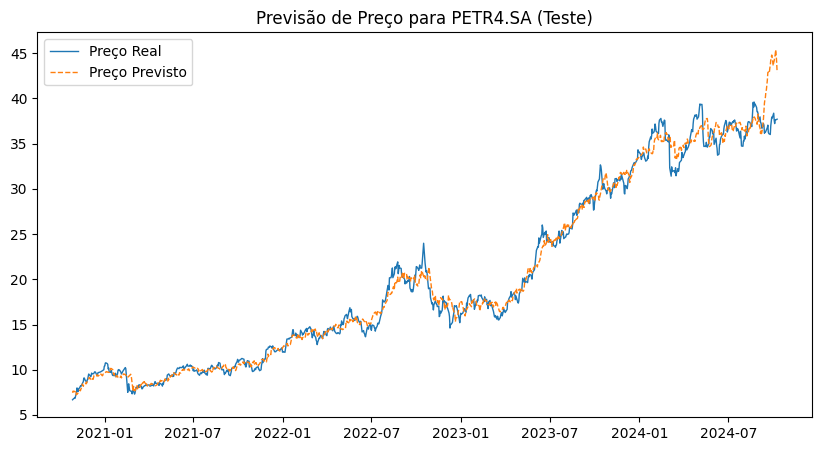

np.float64(1.6837777950091108)

In [5]:
model, scaler, mse, X_train, y_train, X_test, y_test  = linear_regression(data, 'PETR4.SA', h=5, max_lag=5)
mse

Análise de overfitting

A função `plot_overfitting_analysis()` compara o erro quadrático médio (MSE) nos conjuntos de treino e teste.

- Dois gráficos são gerados: um para comparar os valores reais e previstos no treino, e outro para os dados de teste.
- Isso permite avaliar se o modelo sofre de overfitting.

MSE no treino: 0.18304629212004253
MSE no teste: 1.6837777950091108


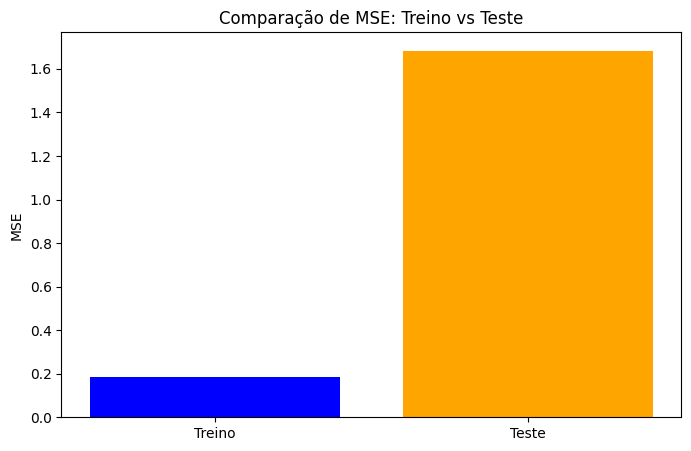

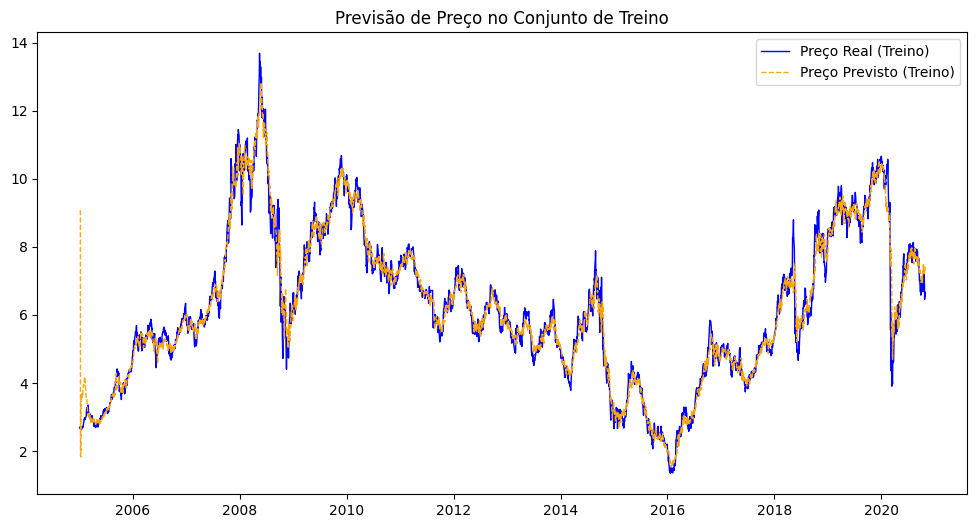

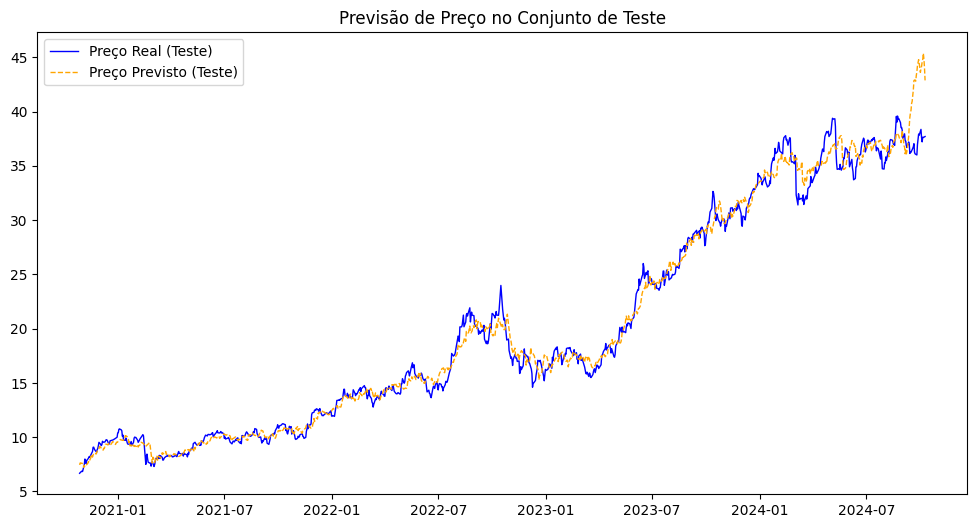

In [6]:
def plot_overfitting_analysis(model, scaler, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(scaler.transform(X_train))
    y_test_pred = model.predict(scaler.transform(X_test))

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    print(f"MSE no treino: {mse_train}")
    print(f"MSE no teste: {mse_test}")

    plt.figure(figsize=(8, 5))
    plt.bar(['Treino', 'Teste'], [mse_train, mse_test], color=['blue', 'orange'])
    plt.title('Comparação de MSE: Treino vs Teste')
    plt.ylabel('MSE')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(y_train.index, y_train, label='Preço Real (Treino)', color='blue', linewidth=1)
    plt.plot(y_train.index, y_train_pred, label='Preço Previsto (Treino)', color='orange', linestyle='--', linewidth=1)
    plt.title('Previsão de Preço no Conjunto de Treino')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Preço Real (Teste)', color='blue', linewidth=1)
    plt.plot(y_test.index, y_test_pred, label='Preço Previsto (Teste)', color='orange', linestyle='--', linewidth=1)
    plt.title('Previsão de Preço no Conjunto de Teste')
    plt.legend()
    plt.show()

plot_overfitting_analysis(model, scaler, X_train, y_train, X_test, y_test)

Prevendo os próximos dias

A função `predict_next_days()` faz previsões de preços para os próximos `h` dias.

- As defasagens nas variáveis preditoras são calculadas.
- O modelo treinado é usado para prever os valores futuros.
- As previsões são plotadas para facilitar a visualização.

In [7]:
def predict_next_days(model, scaler, data, stock, h=5, max_lag=5):
    X_future = pd.DataFrame()

    for lag in range(1, max_lag + 1):
        X_future[f'Seasonality_lag_{lag}'] = data[f'{stock}_close_seasonal'].shift(h + lag)
        X_future[f'Trend_lag_{lag}'] = data[f'{stock}_close_trend'].shift(h + lag)
        X_future[f'Moving_Average_lag_{lag}'] = data[f'{stock}_close_ma'].shift(h + lag)
        X_future[f'Stock_Splits_lag_{lag}'] = data[f'{stock}_stock splits'].shift(h + lag)
        X_future[f'Volume_lag_{lag}'] = data[f'{stock}_volume'].shift(h + lag)
        X_future[f'Residue_lag_{lag}'] = data[f'{stock}_close_resid'].shift(h+lag)

    X_future = X_future.fillna(0)

    X_train_columns = scaler.mean_.shape[0]

    X_future_scaled = scaler.transform(X_future.iloc[-h:])

    future_predictions = model.predict(X_future_scaled)

    last_date = data.index[-1]
    future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, h + 1)]

    plt.figure(figsize=(10, 5))
    plt.plot(future_dates, future_predictions, label=f'Previsão para os próximos {h} dias', linestyle='--', marker='o')
    plt.title(f'Previsão de Preço para {stock} após {h} dias')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.grid(True)
    plt.show()

    return future_predictions


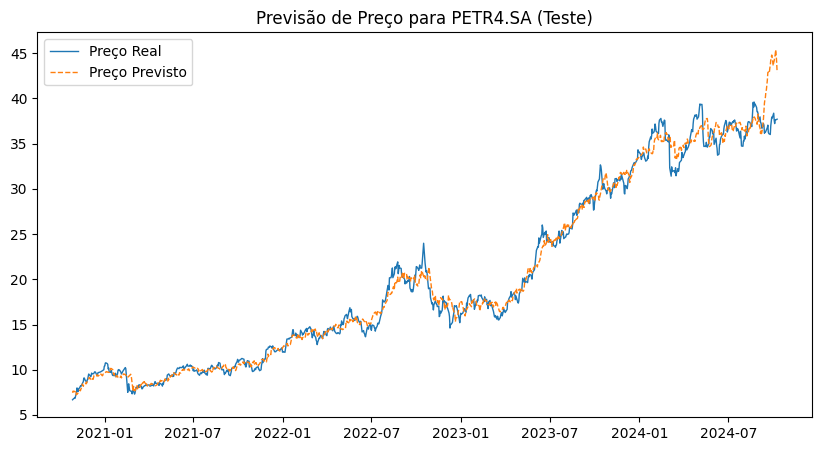

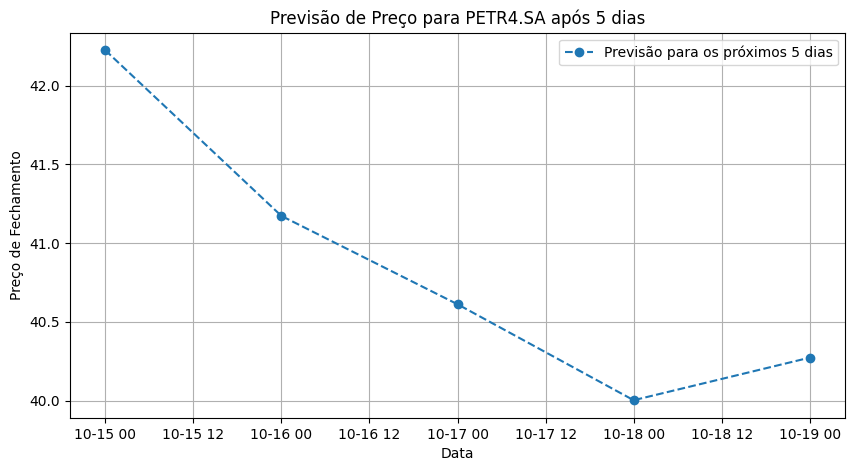

In [8]:
model, scaler, mse, X_train, y_train, X_test, y_test = linear_regression(data, 'PETR4.SA', h=5, max_lag=5)

predictions = predict_next_days(model, scaler, data, 'PETR4.SA', h=5, max_lag=5)
